In [1]:
from __future__ import print_function, division

import os, sys
import numpy as np
import pandas as pd
import pomegranate as pg
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve

# import ghmm and make it quieter
import ghmm
import logging
log = logging.getLogger("GHMM")
log.setLevel(logging.CRITICAL)

# log key package versions
from networkx import __version__ as ntx_version
print("Python      :", sys.version)
print("Numpy       :", np.__version__)
print("Pandas      :", pd.__version__)
print("Pomegranate :", pg.__version__)
print("-- Networkx :", ntx_version)
print("GHMM        : 0.9") # no simple way to get this version, but it's been 0.9 for a while and no updates
print("Workdir     :", os.getcwd())

Python      : 2.7.16 |Anaconda, Inc.| (default, Mar 14 2019, 16:24:02) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy       : 1.15.4
Pandas      : 0.24.2
Pomegranate : 0.11.1
-- Networkx : 2.2
GHMM        : 0.9
Workdir     : /Users/ilya/Desktop/mhcbinding/pomegranate


## Load datasets and configure common parameters

In [2]:
# import datasets
training_set = pd.read_csv('training_set.csv.gz')
test_set = pd.read_csv('test_set.csv.gz')

training_set.info()
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5186 entries, 0 to 5185
Data columns (total 1 columns):
peptide    5186 non-null object
dtypes: object(1)
memory usage: 40.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58277 entries, 0 to 58276
Data columns (total 2 columns):
peptide    58277 non-null object
label      58277 non-null int64
dtypes: int64(1), object(1)
memory usage: 910.6+ KB


In [3]:
# common HMM parameters
numStates = 25
max_iterations = 500    # max number of steps in Baum-Welch
stop_threshold = 0.0001 # log probability change cutoff in Baum-Welch

## Initialize and train the pomegranate-based model

In [4]:
# initialize pomegranate-based HMM

# define the distribution on amino acids (initially equiprobable for each state)
aminoAcidAlpahbet = [
    'A', 'C', 'D', 'E',
    'F', 'G', 'H', 'I',
    'K', 'L', 'M', 'N',
    'P', 'Q', 'R', 'S',
    'T', 'V', 'W', 'Y']
aminoAcidDistribution = {}
for a in aminoAcidAlpahbet:
    aminoAcidDistribution[a] = 1  / len(aminoAcidAlpahbet)
print(aminoAcidDistribution)

# initialize the state randomly
tT = np.random.rand(numStates, numStates)
tT = (tT.T / tT.sum(1)).T # normalize each row to sum to 1
starts = np.ones(numStates) / numStates # equiprobable start states
ends = np.zeros(numStates)
ends[numStates-1] = 1 # one end state

# build the model
hmm_pg = pg.HiddenMarkovModel.from_matrix(
    tT,
    [pg.DiscreteDistribution(aminoAcidDistribution)] * numStates,
    starts,
    ends
)

{'A': 0.05, 'C': 0.05, 'E': 0.05, 'D': 0.05, 'G': 0.05, 'F': 0.05, 'I': 0.05, 'H': 0.05, 'K': 0.05, 'M': 0.05, 'L': 0.05, 'N': 0.05, 'Q': 0.05, 'P': 0.05, 'S': 0.05, 'R': 0.05, 'T': 0.05, 'W': 0.05, 'V': 0.05, 'Y': 0.05}


In [5]:
# convert the training set to the pomegranate-acceptable format
training_set_pg = [list(str(p)) for p in training_set.peptide]

In [6]:
%%time 

# train the model using Baum-Welch

hmm_pg.fit(
    training_set_pg,
    algorithm = 'baum-welch',
    stop_threshold = stop_threshold,
    max_iterations = max_iterations,
    verbose = False,
    n_jobs = 4
)

CPU times: user 52min 8s, sys: 1min 33s, total: 53min 41s
Wall time: 15min


{
    "end" : {
        "distribution" : null,
        "class" : "State",
        "weight" : 1.0,
        "name" : "None-end"
    },
    "name" : "None",
    "distribution ties" : [
        [
            0,
            1
        ],
        [
            0,
            2
        ],
        [
            0,
            3
        ],
        [
            0,
            4
        ],
        [
            0,
            5
        ],
        [
            0,
            6
        ],
        [
            0,
            7
        ],
        [
            0,
            8
        ],
        [
            0,
            9
        ],
        [
            0,
            10
        ],
        [
            0,
            11
        ],
        [
            0,
            12
        ],
        [
            0,
            13
        ],
        [
            0,
            14
        ],
        [
            0,
            15
        ],
        [
            0,
            16
        ],
        [
 

## Initialize and train the GHMM-based model

In [7]:
# initialize GHMM-based HMM

# define the amino acids alphabet with the stop emission
AminoAcidsZ = ghmm.Alphabet(ghmm.AminoAcids.listOfCharacters + ['Z'])

# all states equiprobable as initial, Baum-Welch will adjust
pi = [1] * numStates

# re-use the matrix
# transition probabilities: all random except for the last state,
# which does not map into anything,
# so ghmm will recognize it as the final state
tT[numStates - 1] = np.array([0] * numStates)

# emission probabilities: last state will be emitting only the dedicated stop state 'Z'
# other options not possible:
# - if we do not let the last state emit at all (silent state), ghmm.baumWelch
#   will not work as it does not support silent states
# - if we leave the random emission pattern for the last state, baumWelch complains
#   that the state cannot be reached (And so the model is wrong)
# so we need the dedicated stop state
tE = np.random.rand(numStates, len(AminoAcidsZ))
tE = (tE.T / tE.sum(1)).T # normalize each row to sum to 1
tE[numStates - 1] = np.zeros(len(AminoAcidsZ))
tE[numStates - 1][AminoAcidsZ.internal('Z')] = 1
for i in range(0, numStates - 1):
    tE[i][AminoAcidsZ.internal('Z')] = 0

hmm_ghmm = ghmm.HMMFromMatrices(AminoAcidsZ, ghmm.DiscreteDistribution(AminoAcidsZ), tT, tE, pi)

In [8]:
# convert the training set to the ghmm-acceptable format, adding the dedicated termination symbol Z
training_set_ghmm = ghmm.SequenceSet(AminoAcidsZ, [list(str(p) + 'Z') for p in training_set.peptide])

In [9]:
%%time

# train the model using Baum-Welch

hmm_ghmm.baumWelch(
    training_set_ghmm,
    nrSteps=max_iterations,
    loglikelihoodCutoff=stop_threshold
)

CPU times: user 2min 29s, sys: 306 ms, total: 2min 29s
Wall time: 2min 30s


## Compare the models on the test set

In [10]:
%%time

# predict on test set with pomegranate

predictions_pg = []
for p in test_set.peptide:
    predictions_pg.append(hmm_pg.log_probability(list(str(p))))
# normalize by length
predictions_pg = np.array(predictions_pg) / (test_set.peptide.str.len() + 1) # normalize by length (inc. end state)
test_set['prediction_pg'] = predictions_pg

CPU times: user 19.2 s, sys: 132 ms, total: 19.4 s
Wall time: 20.1 s


In [11]:
%%time

# predict on test set with ghmm

test_set_ghmm = ghmm.SequenceSet(AminoAcidsZ, [list(str(p) + 'Z') for p in test_set.peptide])
prediction_ghmm = hmm_ghmm.loglikelihoods(test_set_ghmm)
prediction_ghmm = np.array(prediction_ghmm) / (test_set.peptide.str.len() + 1) # normalize by length (inc. end state)
test_set['prediction_ghmm'] = prediction_ghmm

CPU times: user 5.45 s, sys: 66 ms, total: 5.52 s
Wall time: 5.66 s


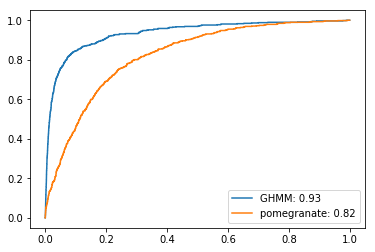

In [12]:
# show ROC curves and AUROCs

auroc_ghmm = roc_auc_score(test_set.label, test_set.prediction_ghmm)
roc_ghmm = roc_curve(test_set.label, test_set.prediction_ghmm)

auroc_pg = roc_auc_score(test_set.label, test_set.prediction_pg)
roc_pg = roc_curve(test_set.label, test_set.prediction_pg)

plt.plot(roc_ghmm[0], roc_ghmm[1], label = 'GHMM: {:.02f}'.format(auroc_ghmm))
plt.plot(roc_pg[0], roc_pg[1], label = 'pomegranate: {:.02f}'.format(auroc_pg))
plt.legend();

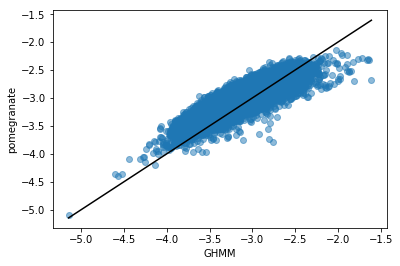

In [13]:
# show the scatter plot

plt.scatter(test_set.prediction_ghmm, test_set.prediction_pg, alpha = 0.5)

# x=y line
lowlim = min(min(test_set.prediction_ghmm), min(test_set.prediction_ghmm))
highlim = max(max(test_set.prediction_ghmm), max(test_set.prediction_ghmm))
plt.plot([lowlim,highlim],[lowlim,highlim], 'black')

plt.xlabel('GHMM')
plt.ylabel('pomegranate');